# Modeling and Simulation 6 - Statistical tests

Statistical tests are crucial tools in analyzing data and making informed decisions based on evidence. We will explore the principles behind the Kolmogorov-Smirnov test and Fisher's Exact test, their applications, and how to perform these kind of tests using Python.

The Kolmogorov-Smirnov test is a non-parametric test used to compare the distribution of a sample with a reference probability distribution or to compare two samples. It's particularly useful when assessing whether a sample comes from a particular distribution. Fisher's Exact test is a statistical significance test used to determine if there are non-random associations between two categorical variables. It's commonly employed in contingency table analysis, especially when dealing with small sample sizes. You will read more details about these tests below.

We are going to need NumPy and SciPy for this lab.

In [44]:
import numpy as np
from scipy.stats import norm, kstest, fisher_exact

## Checking the randomness of Python

### The Kolmogorov-Smirnov test

This [test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) is a statistical test that can be used to check the uniformity of a set of random numbers. The test measures the maximum difference between the cumulative distribution function (CDF) of the observed data and the CDF of the expected uniform distribution. $CDF_X(x)$ is the probability that a _random variable_ X takes a value less than or equal to x.

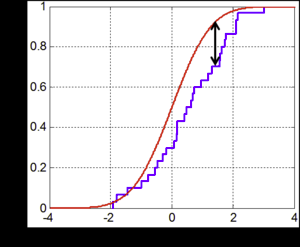

This would be the graphical representation of the K-S test. The red line is the model, our expected CDF. The blue line is an empirical CDF, that being our sample. The biggest difference between the two data sets is the test statistic, represented by the black arrow.

Let's start by defining the function for the Kolmogorov-Smirnov test.

In [45]:
def ks_statistic(sample):
    # we'll need to arrange our data in a given order to make the test
    sample = np.sort(sample)
    n = len(sample)
    
    # we will consider our model CDF to be [0, 1) with n elements
    # since we used a normal distribution
    expected_cdf = np.random.rand(n)
    
    # we now compute our test statistic as the largest difference between the two sets
    diff = np.abs(sample - expected_cdf)
    statistic = np.max(diff)
    
    return statistic

If we were to call this function on a sample of statistically significant size, we should get a number between 0 and 1. But we first need to define a few terms relevant to statistics.

#### Null hypothesis

The null hypothesis is a statement or assumption that is presumed to be true unless there is evidence to the contrary. In statistical hypothesis testing, the null hypothesis often represents the absence of an effect or relationship between variables.

For example, suppose we want to test the hypothesis that a new drug is effective in reducing blood pressure. The null hypothesis would be that the drug has no effect on blood pressure, and any observed difference in blood pressure between the treatment and control groups is due to chance. The alternative hypothesis, in this case, would be that the drug does have a significant effect on blood pressure.

The purpose of hypothesis testing is to determine whether the evidence in the sample supports the null hypothesis or whether it is strong enough to reject it in favor of the alternative hypothesis. The null hypothesis is typically the default assumption in hypothesis testing, and we use statistical methods to calculate the probability of obtaining the observed data or more extreme data under the null hypothesis. If this probability is sufficiently low (i.e., below a predetermined significance level), we reject the null hypothesis and conclude that the alternative hypothesis is more likely.

#### Significance level (α)
The probability of rejecting the null hypothesis when it is actually true. This is usually a parameter that we give to the test (a common value is 0.05)

#### Rejection Region
In hypothesis testing, the rejection region of a statistical test is the range of test statistic values that would lead us to reject the null hypothesis in favor of the alternative hypothesis. The rejection region is determined based on the significance level (alpha) chosen for the test, which represents the maximum probability of rejecting the null hypothesis when it is true.

#### p-value
In statistical hypothesis testing, the p-value is the probability of obtaining a test statistic at least as extreme as the observed value, assuming that the null hypothesis is true. It is used to determine the statistical significance of the results obtained from a hypothesis test.

#### Critical value
It represents the maximum value of a test statistic beyond which the null hypothesis is rejected.

### Back to our task
In the Kolmogorov-Smirnov test *the null hypothesis is that both the sample and the expected CDF are identical*.


In order to qualitatively measure the result of the KS test, we will compute two additional metrics: the p-value and the critical value of the test.

In our case, the p-value will be the probability of obtaining a greater than or equal difference to the one computed, while the critical value will be the difference beyond which we can conclude that the two sets are different.

We will compute the critical value using the formula 
$c(\alpha) / \sqrt{n}$. 
Typically the values $c(\alpha)$ values are taken from a pre-computed table, depending on the chosen alpha and n. For $\alpha = 0.05$, we can approximate it as 1.36.

The p-value can be calculated using the formula 
$$1 - CDF(statistic)$$

In [46]:
def ks_test(sample):
    statistic = ks_statistic(sample)
    n = len(sample)
    
    # TODO
    critical_value = ...
    # hint: norm.cdf
    p_value = ...
    
    return statistic, critical_value, p_value

In [47]:
import time

np.random.seed(int(time.time()))

# we take 1000 random numbers given by a normal distribution (Gaussian)
numbers = np.random.normal(size=1000)

# we create our empirical CDF using scipy.stats.norm.cdf
sample = np.array([norm.cdf(x, loc=0, scale=1) for x in numbers])

# now we compute our KS statistic
statistic, critical_value, p_value = ks_test(sample)

print(f"KS test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Critical value: {critical_value:.4f}")

KS test statistic: 0.9731
p-value: 0.4828
Critical value: 0.0430


Even though the KS test is not a definitive test for determining the quality of Random Number Generators (RNGs), we can see that NumPy's random is pretty good. You can see how it works more in depth [here](https://numpy.org/devdocs/reference/random/index.html). In newer NumPy versions (>1.17), it uses a variant of a [Mersenne Twister 19937](https://en.wikipedia.org/wiki/Mersenne_Twister). You need to keep in mind that even though it produces satisfactory results, it is still a pseudorandom number generator, and it _will not provide crytographically secure numbers_.

P.S.: For a quick KS test, you can call the built-in _scipy_ function:

In [48]:
sample = np.random.rand(1000)
test_statistic, p_value = kstest(sample, 'uniform')

print(f"Test statistic: {test_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

Test statistic: 0.0252
P-value: 0.5426


### Fisher's Exact Test

This test is a statistical method used to determine the significance of the association between two categorical variables in a contingency table, particularly when the sample size is small. Unlike numerical variables, which represent quantities or measurements, categorical variables classify data into distinct groups or categories based on some characteristic or attribute. 

For example, if we were studying the preferences of people for ice cream flavors, the variable `ice cream flavor` would be categorical because it categorizes individuals into groups based on their preferred flavor (e.g., chocolate, vanilla, strawberry).

A contingency table is a tabular representation of the joint distribution of two or more categorical variables. It organizes the data into rows and columns, with each cell in the table representing the count or frequency of observations that fall into a particular combination of categories for the variables being studied.

For hand calculations, the test is feasible only in the case of a 2 × 2 contingency table. However, the principle of the test can be extended to the general case of an m × n table, and some statistical packages provide a calculation (sometimes using a [Monte Carlo method](https://stats.stackexchange.com/questions/1805/fishers-exact-test-in-contingency-tables-larger-than-2x2) to obtain an approximation) for the more general case. For now, suppose we have the following 2×2 table:

|           	| **Class I** 	| **Class II** 	|     **Total**     	|
|:---------:	|:-----------:	|:------------:	|:-----------------:	|
|  **Blue** 	|      `a`      	|       `b`      	|       a + b       	|
|  **Red**  	|      `c`      	|       `d`      	|       c + d       	|
| **Total** 	|    a + c    	|     b + d    	| a + b + c + d = n 	|


The one-tailed p value for Fisher’s Exact Test is calculated as:

$$p = \frac{(a + b)! \; (c + d)! \; (a + c)! \; (b + d)!}{a! \; b! \; c! \; d! \; n!}$$

This produces the same p-value as the CDF of the hypergeometric distribution with the following parameters:

* population size = n
* population “successes” = a+b
* sample size = a + c
* sample "successes" = a

Let's return to the ice cream example. Suppose we surveyed 80 people about their favorite ice cream flavor, and we categorized their preferences into more detailed groups: `Teenagers` (under 18 years old), and `Adults` (over 18 years old). The contingency table for the joint distribution is shown below:


|               	| **Teenagers** 	| **Adults** 	| **Total** 	|
|:-------------:	|:-------------:	|:----------:	|:---------:	|
| **Chocolate** 	|       10      	|     25     	|     35    	|
|  **Vanilla**  	|       15      	|     30     	|     45    	|
|   **Total**   	|       25      	|     55     	|     80    	|


In this table, each cell represents the count of individuals who prefer a specific flavor of ice cream within a particular age group. For example, 10 teenagers prefer Chocolate ice cream and 25 adults prefer Chocolate ice cream. The last row and column show the totals for each age group and each ice cream flavor, respectively.

Now, we'll use the Fisher's Exact test to check if we have a non-random connection between our categorical variables (or, to express it simply, if there is a significant correlation between the ice cream flavors and people that buy it). Let's choose $\alpha = 0.05$ as our significance level.

* $H_0$ (null hypothesis): The two variables are independent.
* $H_1$ (alternative hypothesis): The two variables are not independent.

In [49]:
# Choose the significance level
alpha = 0.05

# TODO Contingency table data
# The data from the last row and column (Total) should not be included.
observed = ...

# TODO Perform Fisher's exact test
odds_ratio, p_value = ...

if p_value <= alpha:
    print("The null hypothesis is rejected!")
else:
    print("Failed to reject the null hypothesis!")

# Print the results
print("Odds Ratio:", odds_ratio)
print(f"P-value: {p_value:.4f}")

Failed to reject the null hypothesis!
Odds Ratio: 0.8
P-value: 0.8084


You should obtain a p-value of $\approx$ 0.8. Since the obtained p-value is greater than $\alpha = 0.05$, we fail to reject the null hypothesis. This indicates that there is no correlation between the ice cream flavors and the age categories that purchase it, and that the two factors are actually independent.

The odds ratio quantifies the likelihood of an event (in our case preferring a certain ice cream flavor) occurring in one group (teenagers) compared to another group (adults). When there is an equal chance that both groups will like flavored ice cream, the odds ratio is 1. In this case, it should be 0.8, meaning that teenagers are less likely to enjoy flavored ice cream than adults. The reverse outcome would occur if the odds ratio was greater than 1.